# NN on sum SciFi and muon detector hits

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'true')

X_train, y_train, X_test, y_test = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000, 2)

In [5]:
#X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

In [6]:
min_clip = 0
#X_train, y_train = operate_datasets.clip_dataset(X_train, y_train, min_clip)

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
X_tens = torch.tensor(X_train).float()#.reshape(-1,1)
y_tens = torch.tensor(y_train).float()

X_test_tens = torch.tensor(X_test).float()#.reshape(-1,1)
y_test_tens = torch.tensor(y_test).float()

In [9]:
X_tens.shape

torch.Size([108000, 2])

In [10]:
def train_iteration(model, optimizer, loss_fn, x_data, y_data):
    y_pred = model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [11]:
class NN(nn.Module):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, 1)

    def forward(self, x, y=None):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def run_training(num_iter):
    model = NN(2, 32) # PyroModule[nn.Linear](1, 1)
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    loss_arr  = []

    optim = torch.optim.Adam(model.parameters(), lr=1e-2)
    #scheduler = ReduceLROnPlateau(optim, 'min', factor=0.1, patience=25, verbose=True)

    for j in range(num_iter):
        loss = train_iteration(model, optim, loss_fn, X_tens, y_tens)

        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
            
        #scheduler.step(loss)
        loss_arr.append(loss.item())
        
    return model, loss_arr

In [13]:
model, loss_arr = run_training(300)

[iteration 0050] loss: 783522.4375
[iteration 0100] loss: 19097.3691
[iteration 0150] loss: 9745.2129
[iteration 0200] loss: 7859.3203
[iteration 0250] loss: 6654.8770
[iteration 0300] loss: 5845.2471


In [14]:
y_pred = model(X_tens).detach().cpu().numpy().squeeze(-1)

In [15]:
y_pred

array([0.17819822, 0.13237676, 0.19587743, ..., 0.1650328 , 0.17651826,
       0.34978336], dtype=float32)

## Visualise results

In [16]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [17]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [18]:
model_name = 'NN on true hits'
save_file_prefix = model_name.replace(' ', '-')

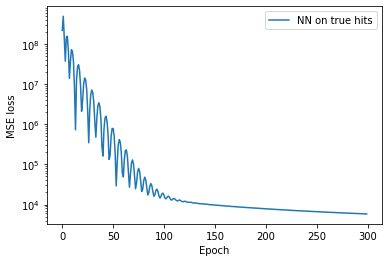

In [19]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key], label=key)
    
    plt.yscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

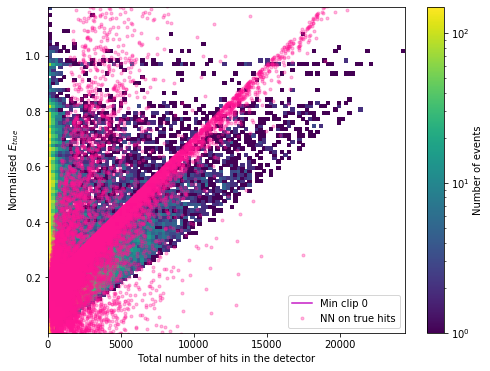

In [20]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, min_clip, model_name,
                                             save_file_prefix=save_file_prefix) 

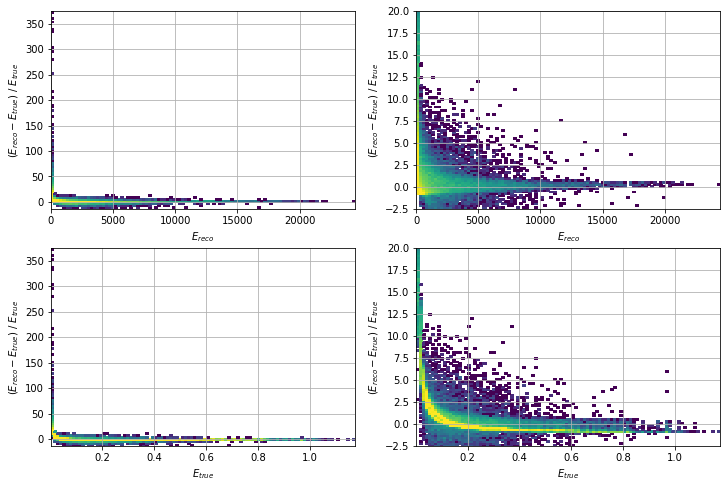

In [21]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 1.50476e+00
std    = 5.84633e+00
median = 2.52620e-01


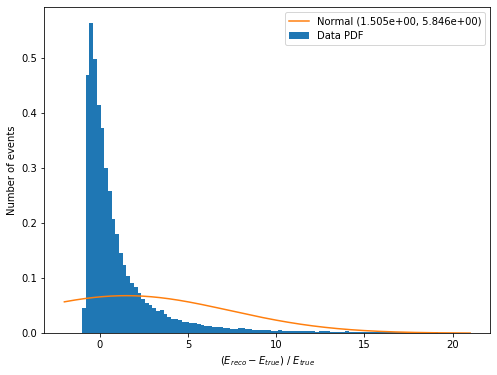

In [22]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [23]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score -0.6782164173757153
max_error 9.208754603005083
mean_absolute_error 0.1429384138601921
mean_squared_error 0.053997374382716075
median_absolute_error 0.10242958740525537
r2_score -0.6878004768417996


,NN-on-true-hits
explained_variance_score,-0.678216
max_error,9.208755
mean_absolute_error,0.142938
mean_squared_error,0.053997
median_absolute_error,0.102430
r2_score,-0.687800
avg_resolution,1.504756
std_resolution,5.846328


## Validation

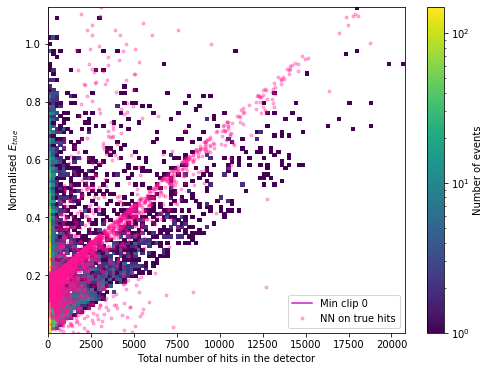

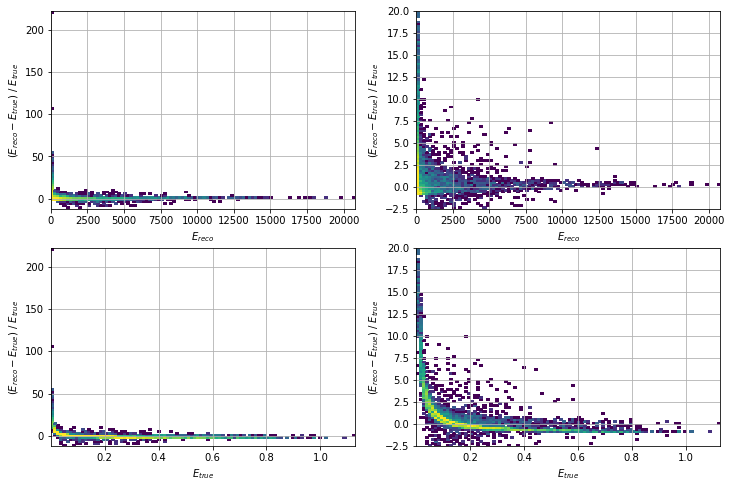

mean   = 1.42116e+00
std    = 4.61085e+00
median = 2.47834e-01


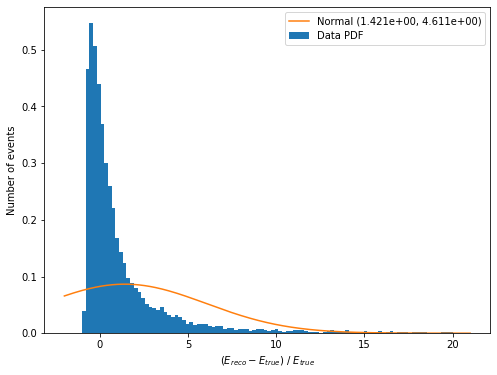

explained_variance_score -0.6267901711524797
max_error 3.0270484787393093
mean_absolute_error 0.14233404021732468
mean_squared_error 0.052131474172739105
median_absolute_error 0.10154030085447897
r2_score -0.63460620033908


,NN-on-true-hits
explained_variance_score,-0.626790
max_error,3.027048
mean_absolute_error,0.142334
mean_squared_error,0.052131
median_absolute_error,0.101540
r2_score,-0.634606
avg_resolution,1.421161
std_resolution,4.610855


In [24]:
X_test = X_test.sum(axis=1).reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_pred_test = model(X_test_tens).detach().numpy().reshape(-1,1)


model_visualisation.plot_2d_energy_hist_clip(X_test, y_test, y_pred_test, min_clip, model_name,
                                             save_file_prefix=save_file_prefix) 

model_visualisation.plot_res_vs_energy(X_test, y_test, y_pred_test, vmax=150,
                                       save_file_prefix=save_file_prefix)  

model_visualisation.plot_res_hist_fit(y_test, y_pred_test, [-1,20],
                                      save_file_prefix=save_file_prefix)

model_evaluation.save_scores(y_test, y_pred_test, save_file_prefix, 
                             folder_path=model_evaluation.TEST_SCORES_DIR)